In [1]:
import pandas as pd
import sqlite3
import seaborn as sns

# Establish connection to sqlite db
cnx = sqlite3.connect('bank_churners.db')
data = pd.read_sql_query('SELECT * FROM bank_churners', cnx)

In [2]:
# Check for missing values
data.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [3]:
# Drop unnecessary columns
data = data.drop(columns= ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,708082083,Existing Customer,45,F,3,High School,Married,Less than $40K,Blue,36,...,3,3,3544.0,1661,1883.0,0.831,15149,111,0.734,0.469
1,708083283,Attrited Customer,58,M,0,Unknown,Single,$40K - $60K,Blue,45,...,1,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
2,708084558,Attrited Customer,46,M,3,Doctorate,Divorced,$80K - $120K,Blue,38,...,3,3,8258.0,1771,6487.0,0.000,1447,23,0.000,0.214
3,708085458,Existing Customer,34,F,2,Uneducated,Single,Less than $40K,Blue,24,...,2,2,1438.3,0,1438.3,0.827,3940,82,0.952,0.000
4,708086958,Existing Customer,49,F,2,Uneducated,Married,Unknown,Blue,41,...,5,2,3128.0,749,2379.0,0.598,4369,59,0.735,0.239


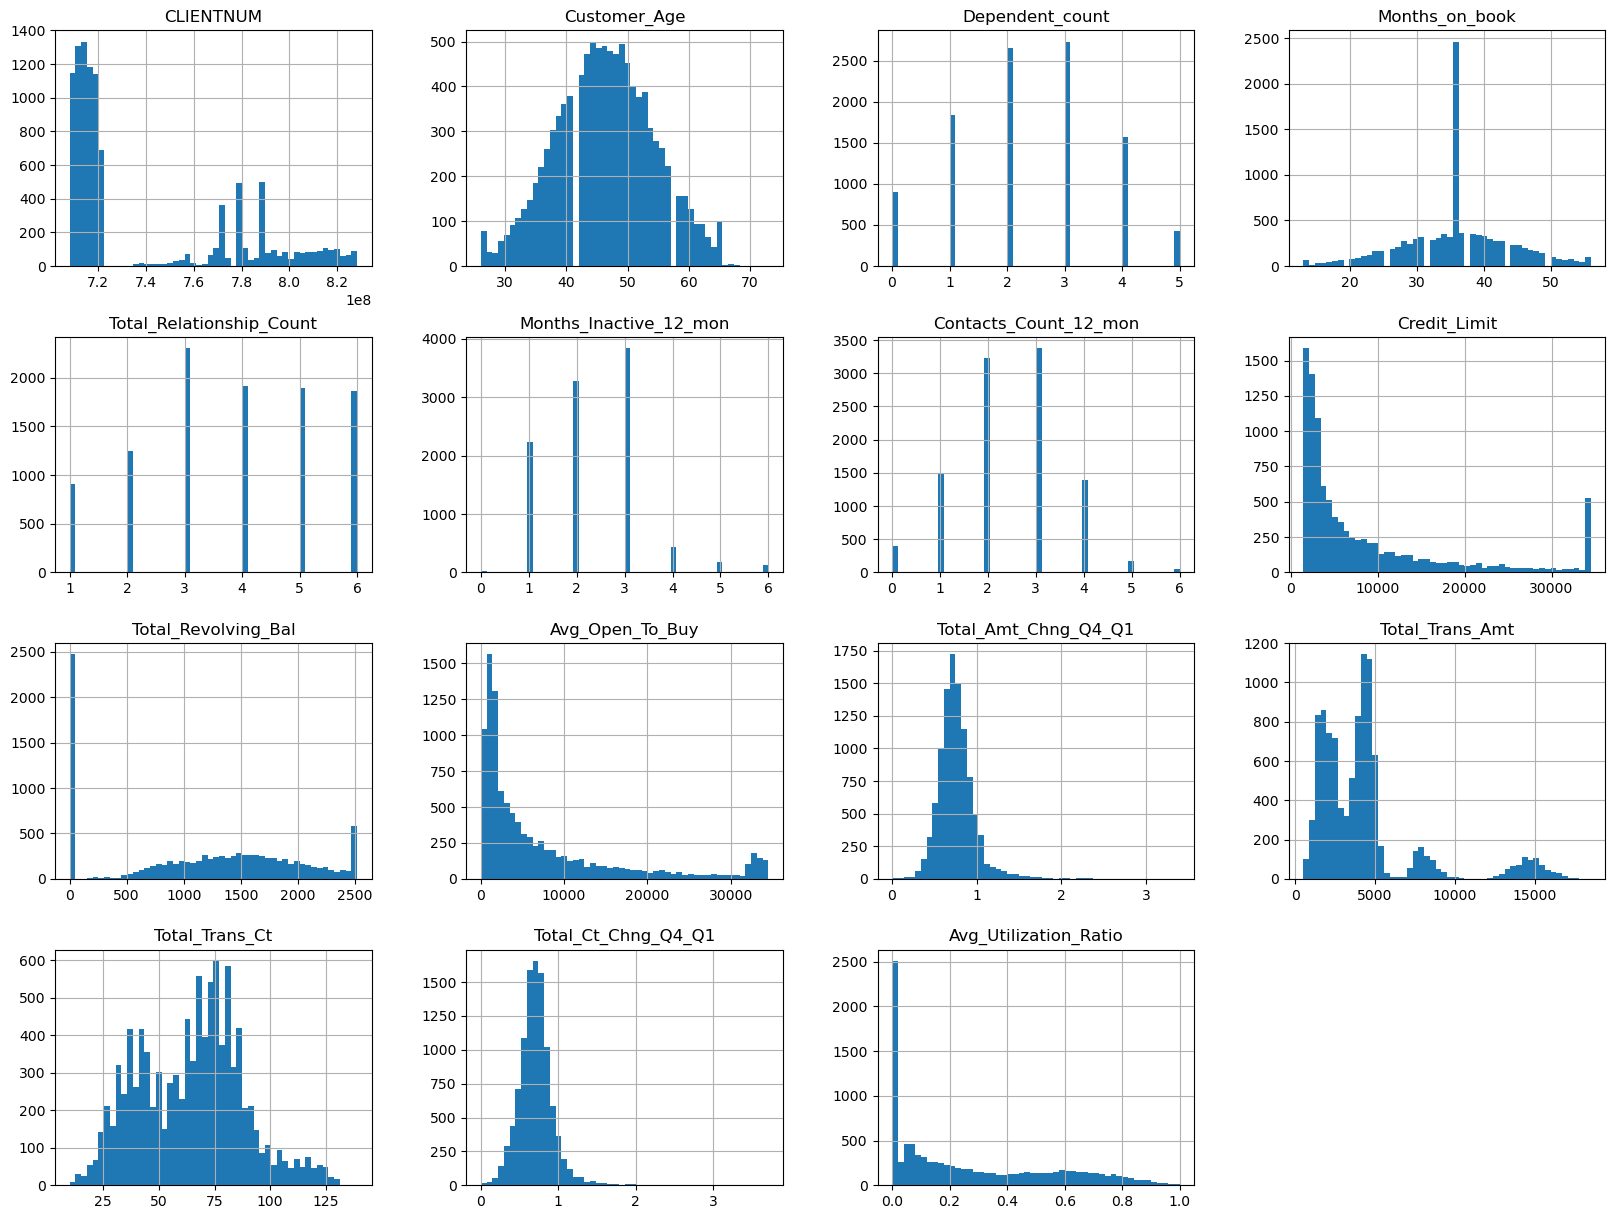

In [4]:
import matplotlib.pyplot as plt

# Plot histograms of numeric columns
data.hist(bins=50, figsize=(20,15))
plt.show()


In [5]:
# Encode Attrition_Flag values
data['Attrition_Flag'] = data['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1})
data.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,708082083,0,45,F,3,High School,Married,Less than $40K,Blue,36,...,3,3,3544.0,1661,1883.0,0.831,15149,111,0.734,0.469
1,708083283,1,58,M,0,Unknown,Single,$40K - $60K,Blue,45,...,1,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
2,708084558,1,46,M,3,Doctorate,Divorced,$80K - $120K,Blue,38,...,3,3,8258.0,1771,6487.0,0.000,1447,23,0.000,0.214


In [6]:
# Handle outliers using z-score
from scipy import stats
import numpy as np
numeric_cols = data.select_dtypes(include=[np.number]).columns

z_scores = stats.zscore(data[numeric_cols])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

In [10]:
# Split data into training and test sets
y = data['Attrition_Flag']
X = data.drop(columns= ['Attrition_Flag'])

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

for feature in categorical_features:
    X[feature] = le.fit_transform(X[feature])


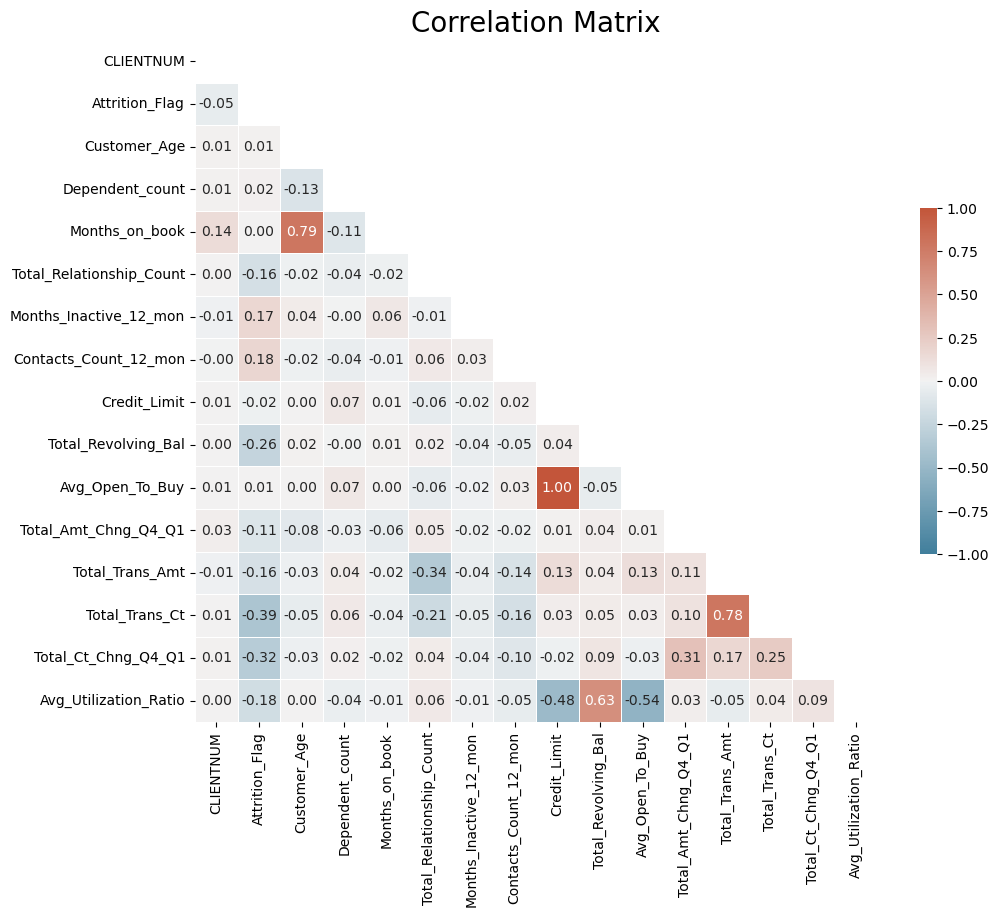

In [33]:
import seaborn as sns

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [13]:
from sklearn.model_selection import train_test_split

# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Import models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Scale features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)


LogisticRegression()

In [16]:
from sklearn.metrics import classification_report

# Predict the test set results
y_pred_knn = knn.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_lr = lr.predict(X_test)

# Print classification report for each model
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn))

print("Decision Tree Classification Report")
print(classification_report(y_test, y_pred_dt))

print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))


KNN Classification Report
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1554
           1       0.82      0.52      0.64       309

    accuracy                           0.90      1863
   macro avg       0.87      0.75      0.79      1863
weighted avg       0.90      0.90      0.89      1863

Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1554
           1       0.78      0.83      0.80       309

    accuracy                           0.93      1863
   macro avg       0.87      0.89      0.88      1863
weighted avg       0.93      0.93      0.93      1863

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1554
           1       0.76      0.57      0.65       309

    accuracy                           0.90      1863
   macro avg       0.84 

In [17]:
from sklearn.dummy import DummyClassifier

# Creating a dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Training the dummy classifier
dummy.fit(X_train, y_train)

# Getting a classification report
y_pred_dummy = dummy.predict(X_test)
print("Dummy Classifier Classification Report")
print(classification_report(y_test, y_pred_dummy))


Dummy Classifier Classification Report
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1554
           1       0.00      0.00      0.00       309

    accuracy                           0.83      1863
   macro avg       0.42      0.50      0.45      1863
weighted avg       0.70      0.83      0.76      1863



/Users/emilyneaville/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyneaville/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyneaville/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [18]:
from sklearn.model_selection import GridSearchCV

# Define the parameter values that should be searched
k_range = list(range(1, 31))

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# Instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit the grid with data
grid.fit(X, y)

# View the complete results
grid.cv_results_


{'mean_fit_time': array([0.00307498, 0.00286095, 0.00282569, 0.00314138, 0.00281248,
        0.00325491, 0.00306392, 0.0029726 , 0.00298076, 0.00278893,
        0.00307214, 0.00296612, 0.00289474, 0.00295591, 0.00331624,
        0.00303698, 0.00309207, 0.00296662, 0.00297587, 0.00310721,
        0.00311201, 0.00333848, 0.00311558, 0.00301745, 0.00305765,
        0.00343812, 0.00369308, 0.00353482, 0.0030163 , 0.00298169]),
 'std_fit_time': array([0.00040205, 0.00046884, 0.00041546, 0.00070941, 0.00030363,
        0.0006484 , 0.00030939, 0.00018389, 0.00026623, 0.00020883,
        0.00040841, 0.00021777, 0.00020771, 0.00024511, 0.00069548,
        0.00024376, 0.00028103, 0.00016231, 0.00021514, 0.00027057,
        0.00041737, 0.00038687, 0.00021301, 0.00022629, 0.00024794,
        0.00056325, 0.00074588, 0.00041044, 0.00023691, 0.00030593]),
 'mean_score_time': array([0.08779488, 0.10433586, 0.11606097, 0.16313181, 0.14544773,
        0.16946619, 0.15065362, 0.14787714, 0.16280999, 0.16

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train)


LogisticRegression()

In [21]:
y_pred = model.predict(X_test_scaled)


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(cm)

acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc}")


Confusion Matrix: 
[[1499   55]
 [ 134  175]]
Model Accuracy: 0.8985507246376812


In [23]:
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier object
dtc = DecisionTreeClassifier()

# Train the model using the training sets
dtc.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred_dtc = dtc.predict(X_test_scaled)


In [24]:
# Model Accuracy
acc_dtc = accuracy_score(y_test, y_pred_dtc)
print(f"Decision Tree Model Accuracy: {acc_dtc}")


Decision Tree Model Accuracy: 0.9345142243692969


In [25]:
feature_importances = dtc.feature_importances_
print("Feature importances:\n", feature_importances)


Feature importances:
 [1.61191024e-02 3.32212410e-02 7.47218382e-04 5.05166251e-03
 8.84017882e-03 8.54851374e-03 8.03901714e-03 2.20057296e-04
 8.26101877e-03 8.88069827e-02 9.95369531e-03 1.33911352e-02
 1.22703155e-02 1.79122033e-01 1.93192629e-02 5.06708042e-02
 1.60432518e-01 2.99255595e-01 6.84787769e-02 9.25087130e-03]


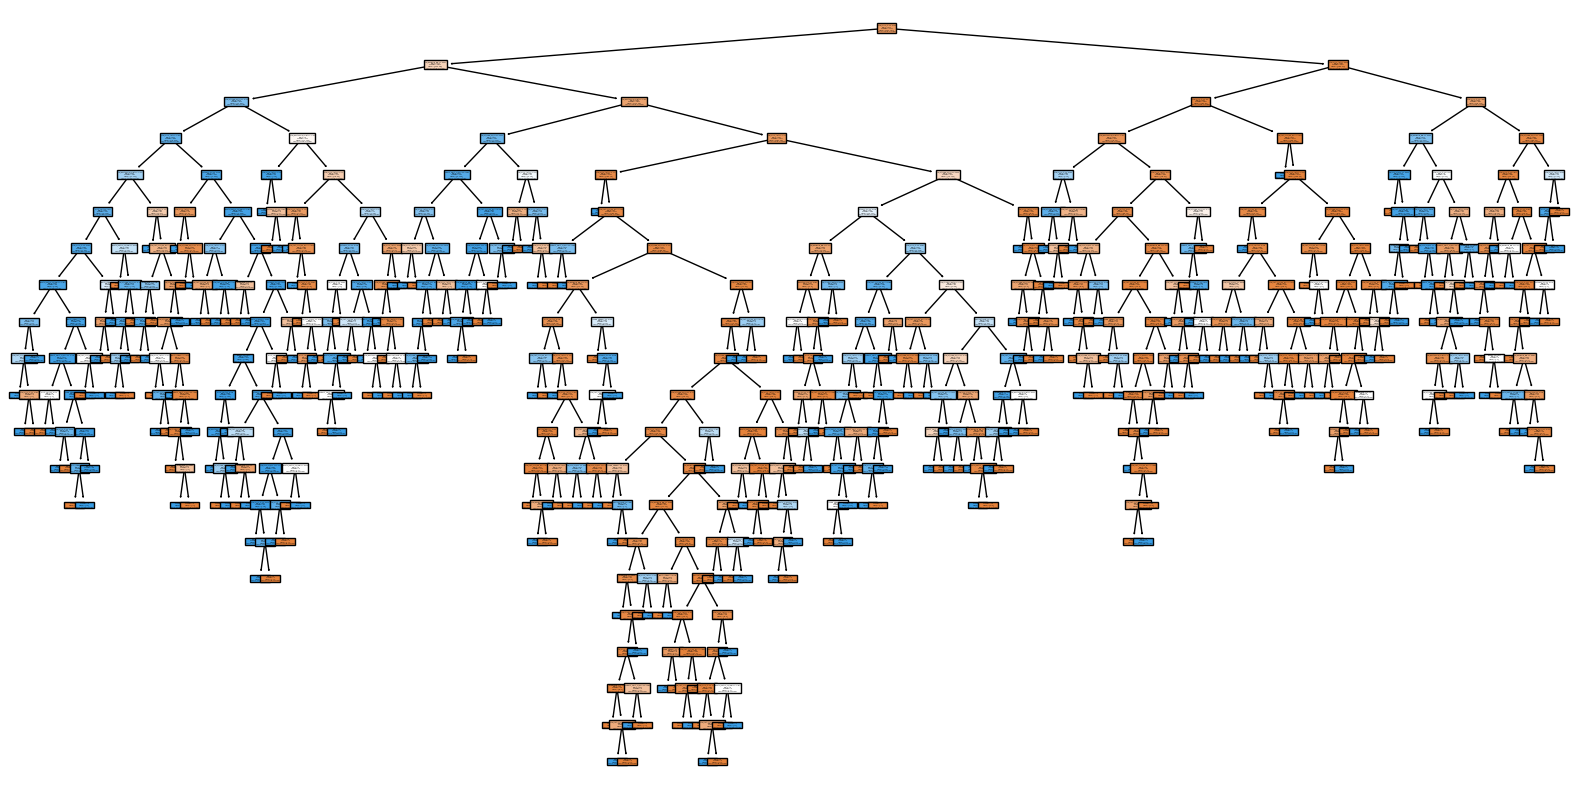

In [26]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))  
_ = plot_tree(dtc, 
              feature_names=X.columns,
              class_names=['Existing Customer', 'Attrited Customer'],
              filled=True)


In [27]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross validation
scores = cross_val_score(dtc, X_train_scaled, y_train, cv=5)
print("Cross-validation scores: ", scores)
print("Average cross-validation score: ", scores.mean())


Cross-validation scores:  [0.93087248 0.92214765 0.93557047 0.93355705 0.91946309]
Average cross-validation score:  0.9283221476510066


In [28]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict the response for test dataset
y_pred_dtc = dtc.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dtc)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(y_test, y_pred_dtc)
print("Classification Report:\n", cr)


Confusion Matrix:
 [[1483   71]
 [  51  258]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1554
           1       0.78      0.83      0.81       309

    accuracy                           0.93      1863
   macro avg       0.88      0.89      0.88      1863
weighted avg       0.94      0.93      0.94      1863



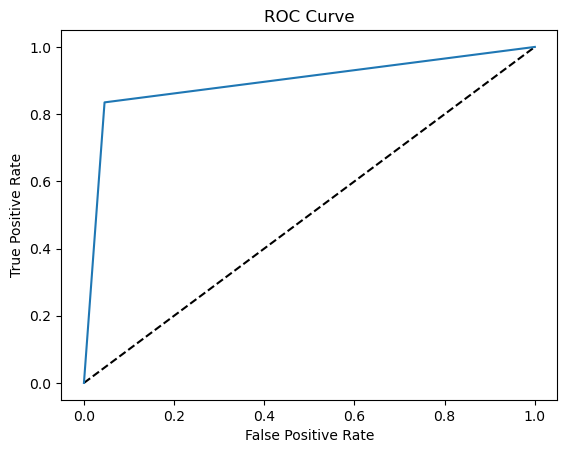

AUC:  0.8946314553110671


In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = dtc.predict_proba(X_test_scaled)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
